# Imports

In [1]:
import os

import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

import core.config.config_ as ccocon
import core.plotting as cplot
import helpers.s3 as hs3
import research.cc.statistics as rccsta

/app/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


# Config

In [2]:
def get_cmtask323_config() -> ccocon.Config:
    """
    Get task323-specific config.
    """
    config = ccocon.Config()
    # Load parameters.
    config.add_subconfig("load")
    config["load"]["aws_profile"] = "am"
    config["load"]["data_dir"] = os.path.join(hs3.get_path(), "data")
    # Data parameters.
    config.add_subconfig("data")
    config["data"]["data_type"] = "OHLCV"
    config["data"]["universe_version"] = "v0_3"
    #        config["data"]["universe_version"] = "v0_1"
    config["data"]["vendor"] = "CCXT"
    # Column names.
    config.add_subconfig("column_names")
    config["column_names"]["volume"] = "volume"
    config["column_names"]["currency_pair"] = "currency_pair"
    config["column_names"]["exchange"] = "exchange_id"
    config["column_names"]["close"] = "close"
    return config


config = get_cmtask323_config()
print(config)

load:
  aws_profile: am
  data_dir: s3://alphamatic-data/data
data:
  data_type: OHLCV
  universe_version: v0_3
  vendor: CCXT
column_names:
  volume: volume
  currency_pair: currency_pair
  exchange: exchange_id
  close: close


# Functions

In [3]:
def compute_volatility_for_each_coin(data, freq):
    """
    Loads and transforms each (exchange-coin) dataframe to compute 18-period
    ema volatility.

    Parameters: DataFrame, resampling frequency
    """
    data["date"] = data.index
    new_df = data.groupby(
        ["currency_pair", "exchange_id", pd.Grouper(key="date", freq=freq)]
    )["close"].last()
    new_df = new_df.pct_change().transform(
        lambda x: x.ewm(span=18, adjust=False).std()
    )
    new_df = new_df.reset_index()
    return new_df


def daily_close(data, freq):
    """
    Loads and transforms each (exchange-coin) dataframe to compute volatility
    for the whole period.

    Parameters: DataFrame, resampling frequency
    """
    data["date"] = data.index
    new_df = data.groupby(
        ["currency_pair", "exchange_id", pd.Grouper(key="date", freq=freq)]
    )["close"].last()
    new_df = new_df.reset_index()
    return new_df


def get_df_with_coin_price_volatility(data, display_plot):
    """
    Unifies volatility values for each coin and plot the graph.

    Parameters: DataFrame with computed volatility, boolean value to plot the graph
    """
    vix_df = data.groupby(
        ["currency_pair", pd.Grouper(key="date", freq=frequency)]
    )["close"].mean()
    vix_df = vix_df.to_frame()
    vix_df.columns = ["ema_volatility"]
    if display_plot:
        sns.set(rc={"figure.figsize": (15, 8)})
        sns.lineplot(
            data=vix_df, x="date", y="ema_volatility", hue="currency_pair"
        )
    return vix_df


def get_overall_returns_volatility(data, display_plot):
    """
    Unifies volatility values for each coin for the whole period and plot the
    barplot.

    Parameters: DataFrame with computed volatility, boolean value to plot the graph
    """
    close_df = daily_close.groupby(
        ["currency_pair", pd.Grouper(key="date", freq=frequency)]
    )["close"].mean()
    rets_df = close_df.groupby(["currency_pair"]).pct_change()
    std_df = rets_df.groupby(["currency_pair"]).std()
    if display_plot:
        cplot.plot_barplot(
            std_df.sort_values(ascending=False),
            title="Volatility per coin for the whole period (1-day basis, log-scaled)",
            figsize=[15, 7],
            yscale="log",
        )
    return std_df


def perform_adf_test(df_daily):
    """
    Performs ADF test to check the stationarity of volatility values
    Parameters: Daily DataFrame with computed volatility
    """
    final_result = []
    coin_list = df_daily.reset_index()["currency_pair"].unique()
    for coin in coin_list:
        result = pd.DataFrame()
        df = df_daily.loc[[coin]]
        df = df[df["ema_volatility"].notna()].copy()
        X = df["ema_volatility"].values
        test_result = adfuller(X)
        result.loc[f"{coin}", "ADF Statistic"] = test_result[0]
        result.loc[f"{coin}", "p-value"] = test_result[1]
        final_result.append(result)
    final_result = pd.concat(final_result)
    final_result["is_unit_root_and_non-stationary (5% sign. level)"] = (
        final_result["p-value"] > 0.05
    )
    return final_result

# Volatility Analysis

## 1 day

In [4]:
frequency = "1D"
compute_daily_vix_ema = lambda data: compute_volatility_for_each_coin(
    data, freq=frequency
)
daily_vix_ema = rccsta.compute_stats_for_universe(config, compute_daily_vix_ema)

Removed 36 / 763283 = 0.00% rows
Removed 36 / 780707 = 0.00% rows
Removed 16 / 362591 = 0.00% rows
Removed 36 / 780749 = 0.00% rows
Removed 35 / 747070 = 0.00% rows
Removed 31 / 607430 = 0.01% rows
Removed 32 / 618181 = 0.01% rows


ema_volatility
currency_pair date                                     
ADA/USDT      2018-08-16 00:00:00-04:00             NaN
              2018-08-17 00:00:00-04:00             NaN
              2018-08-18 00:00:00-04:00        0.134677
              2018-08-19 00:00:00-04:00        0.095983
              2018-08-20 00:00:00-04:00        0.105726
...                                                 ...
XRP/USDT      2021-09-17 00:00:00-04:00        0.050253
              2021-09-18 00:00:00-04:00        0.047576
              2021-09-19 00:00:00-04:00        0.051101
              2021-09-20 00:00:00-04:00        0.048980
              2021-09-21 00:00:00-04:00        0.049852

[9605 rows x 1 columns]

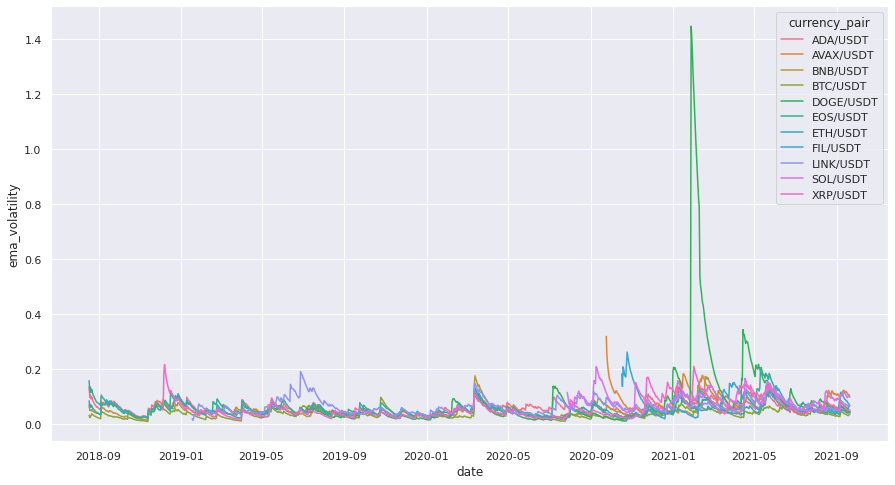

In [5]:
ema_df_daily = get_df_with_coin_price_volatility(daily_vix_ema, display_plot=True)
display(ema_df_daily)

## 5 min

In [6]:
frequency = "5min"
compute_5min_vix_ema = lambda data: compute_volatility_for_each_coin(
    data, freq=frequency
)
vix_ema_5min = rccsta.compute_stats_for_universe(config, compute_5min_vix_ema)

Removed 36 / 763283 = 0.00% rows
Removed 36 / 780707 = 0.00% rows
Removed 16 / 362591 = 0.00% rows
Removed 36 / 780749 = 0.00% rows
Removed 35 / 747070 = 0.00% rows
Removed 31 / 607430 = 0.01% rows
Removed 32 / 618181 = 0.01% rows


ema_volatility
currency_pair date                                     
ADA/USDT      2018-08-16 20:00:00-04:00             NaN
              2018-08-16 20:05:00-04:00             NaN
              2018-08-16 20:10:00-04:00        0.000603
              2018-08-16 20:15:00-04:00        0.000425
              2018-08-16 20:20:00-04:00        0.001439
...                                                 ...
XRP/USDT      2021-09-21 18:50:00-04:00        0.006339
              2021-09-21 18:55:00-04:00        0.006714
              2021-09-21 19:00:00-04:00        0.006792
              2021-09-21 19:05:00-04:00        0.006533
              2021-09-21 19:10:00-04:00        0.006414

[2763341 rows x 1 columns]

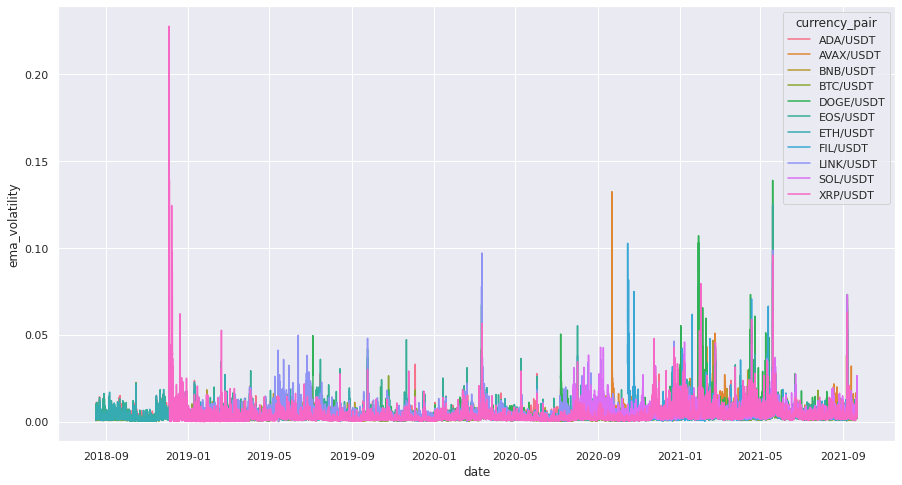

In [7]:
ema_df_5min = get_df_with_coin_price_volatility(vix_ema_5min, display_plot=True)
display(ema_df_5min)

## Volatility for the whole period (1-day frequency)

In [8]:
frequency = "1D"
compute_daily_close = lambda data: daily_close(data, freq=frequency)
daily_close = rccsta.compute_stats_for_universe(config, compute_daily_close)

Removed 36 / 763283 = 0.00% rows
Removed 36 / 780707 = 0.00% rows
Removed 16 / 362591 = 0.00% rows
Removed 36 / 780749 = 0.00% rows
Removed 35 / 747070 = 0.00% rows
Removed 31 / 607430 = 0.01% rows
Removed 32 / 618181 = 0.01% rows


currency_pair
ADA/USDT     0.060776
AVAX/USDT    0.095851
BNB/USDT     0.056449
BTC/USDT     0.039844
DOGE/USDT    0.181408
EOS/USDT     0.062374
ETH/USDT     0.051847
FIL/USDT     0.083435
LINK/USDT    0.070473
SOL/USDT     0.096528
XRP/USDT     0.065472
Name: close, dtype: float64

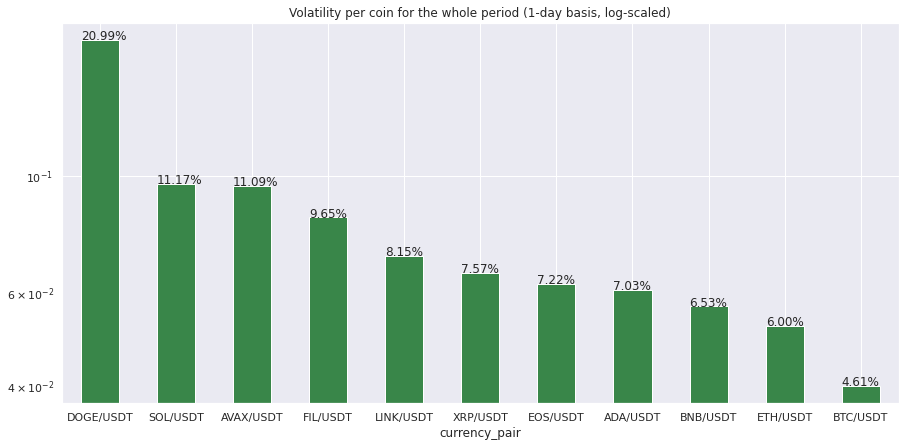

In [9]:
std_df = get_overall_returns_volatility(daily_close, display_plot=True)
display(std_df)

# Test for stationarity of volatility

In [10]:
test_results = perform_adf_test(ema_df_daily)
display(test_results)

,ADF Statistic,p-value,is_unit_root_and_non-stationary (5% sign. level)
ADA/USDT,-5.419227,3.086075e-06,False
AVAX/USDT,-6.321419,3.059519e-08,False
BNB/USDT,-5.326428,4.826044e-06,False
BTC/USDT,-5.544240,1.674843e-06,False
DOGE/USDT,-4.991235,2.309687e-05,False
EOS/USDT,-4.550113,1.594639e-04,False
ETH/USDT,-5.771600,5.376380e-07,False
FIL/USDT,-2.565722,1.002909e-01,True
LINK/USDT,-4.643783,1.071815e-04,False
SOL/USDT,-4.649945,1.043902e-04,False


After test results we see that __FIL/USDT__ volatility over 1-day is failed to pass the stationarity test. The graph below confirms the persistence of trend: seems like the coin was too volatile right after the listing and failed to keep the same levels during its trading lifetime.

<AxesSubplot:xlabel='date', ylabel='ema_volatility'>

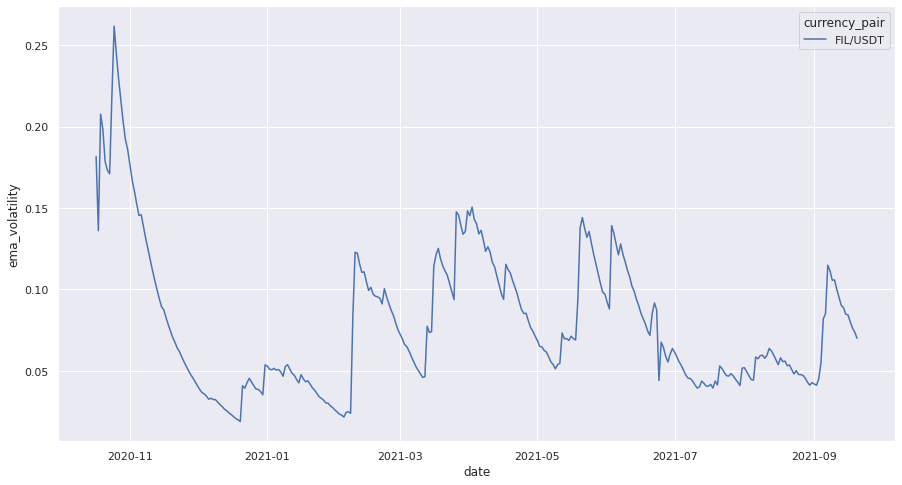

In [11]:
sns.lineplot(
    data=ema_df_daily.loc[["FIL/USDT"]].reset_index(),
    x="date",
    y="ema_volatility",
    hue="currency_pair",
)